In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [9]:
!pip install -U bayesian-optimization

In [22]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
warnings.filterwarnings('ignore')
# 한글 폰트 설정
# plt.rc('font', family='Malgun Gothic')
# 구글드라이브 마운트 경로 설정
drive_path = '/content/drive/MyDrive/data/'

In [3]:
# 환율 CSV 파일 로드
train = pd.read_table(drive_path + 'exchange_rate_train.csv', sep=",", thousands=',', encoding='CP949')
test = pd.read_table(drive_path + 'exchange_rate_test.csv', sep=",", thousands=',', encoding='CP949')
# 결측치 제거
train = train.dropna()
test = test.dropna()
# 일본만 선택해서 테스트
train = train[train['국가명'] == '일본']
test = test[test['국가명'] == '일본']
train.head()

,통화코드,국가명,날짜,매매기준율,미달러환산율,주화매입률,주화매도율,현찰매입률,현찰매도율,수표매입률,...,여행자수표매입률,여행자수표매도율,DAX,VN,S&P 500,KOSPI,FTSE,DOWJONES,NIKKEI,NASDAQ
28,JPY,일본,2016-01-04,992.62,0.8384,496.31,1488.93,977.74,1007.50,980.32,...,982.70,1002.54,10283.44,574.41,2012.66,235.00,6093.43,17148.94,18450.98,4497.86
84,JPY,일본,2016-01-05,993.00,0.8380,496.50,1489.50,978.11,1007.89,980.69,...,983.07,1002.93,10310.10,569.94,2016.71,236.40,6137.24,17158.66,18374.00,4484.18
140,JPY,일본,2016-01-06,1005.06,0.8439,502.53,1507.59,989.99,1020.13,992.60,...,995.01,1015.11,10214.02,574.57,1990.26,235.45,6073.38,16906.51,18191.32,4443.98
196,JPY,일본,2016-01-07,1016.95,0.8475,508.48,1525.42,1001.70,1032.20,1004.34,...,1006.79,1027.11,9979.85,565.36,1943.09,232.50,5954.08,16514.10,17767.34,4305.72
252,JPY,일본,2016-01-08,1013.12,0.8464,506.56,1519.68,997.93,1028.31,1000.56,...,1002.99,1023.25,9849.34,560.05,1922.03,233.80,5912.44,16346.45,17697.96,4270.78


In [4]:
# 범주형 변수 인코딩
encoder = LabelEncoder()
encoder.fit(train['통화코드'])
train["통화코드"] = encoder.transform(train['통화코드'])
encoder = LabelEncoder()
encoder.fit(train['국가명'])
train["국가명"] = encoder.transform(train['국가명'])
encoder = LabelEncoder()
encoder.fit(train['날짜'])
train["날짜"] = encoder.transform(train['날짜'])

In [24]:
x = train[['DAX','VN','S&P 500','KOSPI','FTSE','DOWJONES','NIKKEI','NASDAQ' ]]
y = train[['매매기준율']]
target = test[['DAX','VN','S&P 500','KOSPI','FTSE','DOWJONES','NIKKEI','NASDAQ' ]]
#train, test split
x_train, x_valid, y_train, y_valid = train_test_split(x, y,
                                                      test_size=0.2, random_state=7279)

In [25]:
x.head()

,DAX,VN,S&P 500,KOSPI,FTSE,DOWJONES,NIKKEI,NASDAQ
28,10283.44,574.41,2012.66,235.00,6093.43,17148.94,18450.98,4497.86
84,10310.10,569.94,2016.71,236.40,6137.24,17158.66,18374.00,4484.18
140,10214.02,574.57,1990.26,235.45,6073.38,16906.51,18191.32,4443.98
196,9979.85,565.36,1943.09,232.50,5954.08,16514.10,17767.34,4305.72
252,9849.34,560.05,1922.03,233.80,5912.44,16346.45,17697.96,4270.78


In [26]:
# 랜덤포레스트 최적 하이퍼파라미터 탐색 범위 설정
params = {
    'n_estimators': (300, 400), #랜덤포레스트 안의 결정 트리 갯수
    'max_depth': (12, 14), #트리의 최대 깊이
    'min_samples_leaf': (2, 14), #리프노드가 되기 위한 최소한의 샘플 데이터 수
    'min_samples_split': (2, 14) #노드를 분할하기 위한 최소한의 데이터 수
}

In [27]:
# 하이퍼 파라미터 최적화
from bayes_opt import BayesianOptimization

# 하이퍼파라미터 최적화를 위한 목적 함수를 정의
def rf_bo(max_depth, n_estimators, min_samples_split, min_samples_leaf):
    # 랜덤 포레스트 모델의 하이퍼파라미터를 설정
    rf_params = {
        'max_depth': int(round(max_depth)),
        'n_estimators': int(round(n_estimators)),
        'min_samples_split': int(round(min_samples_split)),
        'min_samples_leaf': int(round(min_samples_leaf)),
    }

    # RandomForestRegressor 모델을 초기화
    rf = RandomForestRegressor(**rf_params)

    # 모델을 훈련 데이터로 학습
    rf.fit(x_train, y_train.values.ravel())

    # 모델의 성능을 평가하고 반환
    score = rf.score(x_train, y_train)
    return score

# BayesianOptimization 객체를 생성
BO_rf = BayesianOptimization(f=rf_bo, verbose=2, pbounds=params, random_state=7279)

# 초기 데이터 포인트 10개를 사용하여 하이퍼파라미터 최적화를 시작하고,
# 그 후 10번의 반복(iteration)을 통해 최적화를 진행
BO_rf.maximize(init_points=10, n_iter=10)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.9473    | 12.59     | 13.75     | 7.676     | 332.9     |
| 2         | 0.9465    | 12.1      | 13.89     | 10.58     | 386.2     |
| 3         | 0.956     | 12.92     | 11.96     | 13.52     | 353.8     |
| 4         | 0.9608    | 12.37     | 11.44     | 4.938     | 357.3     |
| 5         | 0.9676    | 13.85     | 9.379     | 5.718     | 379.4     |
| 6         | 0.956     | 12.23     | 11.53     | 6.87      | 320.2     |
| 7         | 0.972     | 12.5      | 7.577     | 5.998     | 349.8     |
| 8         | 0.9559    | 13.9      | 11.81     | 10.33     | 380.9     |
| 9         | 0.9794    | 13.58     | 5.644     | 5.235     | 320.6     |
| 10        | 0.952     | 13.02     | 12.54     | 9.573     | 399.8     |
| 11        | 0.9637    | 12.2      | 9.744     | 9.301     | 386.2     |
| 12        | 0.9646    | 12.32     | 

In [28]:
# 평균절대비율오차 MAPE 계산 함수
def MAPE(predict, test):
    cnt = 0
    idx = 0
    for i in range(len(predict)):
        if predict[i] == test[i] == 0:
            pass
        else:
            cnt += (abs(test[i] - predict[i]) / test[i]) * 100
            idx += 1
    return cnt / idx

In [29]:
from sklearn.metrics import r2_score

max_params = BO_rf.max['params']
max_params['max_depth'] = int(max_params['max_depth'])
max_params['n_estimators'] = int(max_params['n_estimators'])
max_params['min_samples_leaf'] = int(max_params['min_samples_leaf'])
max_params['min_samples_split'] = int(max_params['min_samples_split'])
print('최적 하이퍼파라미터:',max_params,'\n')

BO_tuend_rf = RandomForestRegressor(**max_params)
BO_tuend_rf.fit(x_train, y_train.values.ravel())
BO_predict = BO_tuend_rf.predict(target)

print("RMSE: {}".format(math.sqrt(mean_squared_error(BO_predict, test[['매매기준율']]))),'\n')
print("MAPE:", MAPE(BO_predict, test[['매매기준율']].values.ravel()).round(4),'%','\n')
r2 = r2_score(test['매매기준율'],BO_predict)
Adj_r2 = 1-(1-r2)*(len(x)-1)/(len(x)-len(test['매매기준율']-1))
print('r2_score: ', r2.round(4), '\nadj_r2_score:', Adj_r2.round(4),'\n')

최적 하이퍼파라미터: {'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 315} 

RMSE: 80.32220465932949 

MAPE: 7.5353 % 

r2_score:  -4.8386 
adj_r2_score: -5.8747 



In [30]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)  # 생략없이 모든 행, 열 출력
# 학습된 모델로 test의 관객 수 예측
예측값 = pd.DataFrame(BO_predict, columns=['예측'])
예측값['예측'] = 예측값['예측'].astype(int)
실제값 = pd.DataFrame(test['매매기준율']).astype(int)
값 = pd.concat([예측값, 실제값], axis=1)
값.rename(columns = {'매매기준율' : '실제'}, inplace = True)
#값.set_index(test['날짜'], inplace=True)
# print(값)
BO_predict


# %matplotlib qt5
# 값.plot(ylim=(0, 6000000),marker='o', ms=5,xlabel='')
# plt.rc('axes', labelsize=12)   # x,y축 label 폰트 크기
# plt.rc('figure', titlesize=15) # figure title 폰트 크기
# plt.rc('xtick', labelsize=10)  # x축 눈금 폰트 크기
# plt.rc('ytick', labelsize=12)  # y축 눈금 폰트 크기

# plt.title("예측 매매기준율과 실제 매매기준율 추이")
# plt.show()

array([1036.05338788, 1038.37164138, 1045.52323862, 1044.77357264,
       1045.08206469, 1036.87708505, 1044.2298957 , 1044.90362445,
       1043.97134131, 1053.86954851, 1050.07825031, 1054.09382298,
       1054.12693004, 1061.32547851, 1061.42254953, 1058.4051773 ,
       1061.51541314, 1056.31989484, 1057.52241147, 1051.16806242,
       1051.29935102, 1059.34613596, 1054.43865394, 1051.86385984,
       1058.52842792, 1060.74262417, 1060.53839587, 1062.89932665,
       1061.5086061 , 1061.93645133, 1061.97357408, 1063.3807915 ,
       1062.97500445, 1059.41809123, 1059.46581609, 1062.2456361 ,
       1062.12199226, 1062.29545431, 1062.48097623, 1062.98207616,
       1062.20767022, 1062.24772389, 1061.58395217, 1043.78367777,
       1047.53443231, 1046.61349059, 1046.78238932, 1046.03104549,
       1046.17240693, 1048.3477018 , 1054.3187415 , 1050.82080006,
       1048.36053292, 1054.76426898, 1059.66536162, 1053.66873873,
       1057.6975059 , 1057.68817166, 1054.36188284, 1055.37860

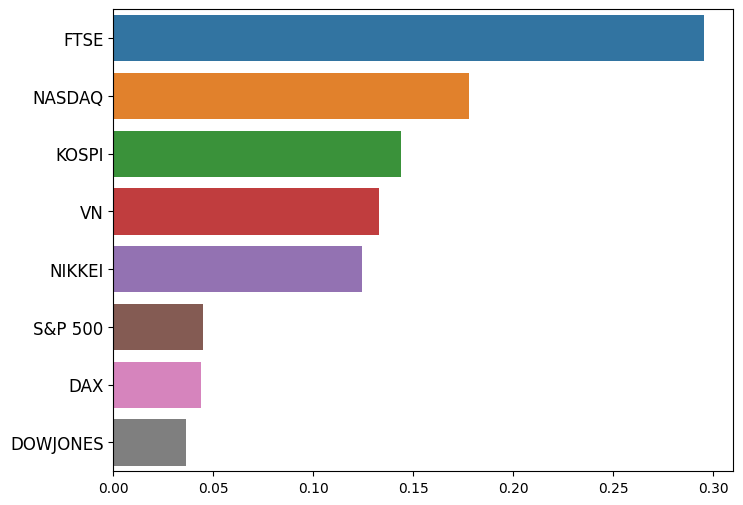

In [32]:
ftr_importances_values = BO_tuend_rf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=x_train.columns)
ftr_top = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8, 6))
sns.barplot(x=ftr_top, y=ftr_top.index)
plt.show()